In [2]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

import os
import pickle
import numpy as np

from PIL import Image
from skimage import io

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
a = 64
from math import *

def between_angles(y, x, theta1, theta2):
    return degrees(atan2(y, x)) >= theta1 and degrees(atan2(y, x)) <= theta2

def in_front(x, y):
    return x >= 0 and x <= a and degrees(atan2(y, x)) <= 35 and degrees(atan2(y, x)) >= -35

def in_front_left(x, y):
    if x == 0:
        return y >= 0
    
    return x <= a and y <= a and between_angles(y, x, 25, 95)

def in_front_right(x, y):
    if x == 0:
        return y <= 0
    
    return y <= 0 and degrees(atan2(y, x)) <= -25 and degrees(atan2(y, x)) >= -95

def in_back(x, y):
    return x <= 0 and (between_angles(y, x, 145, 180) or between_angles(y, x, -180, -145))

def in_back_left(x, y):
    if x == 0:
        return y >= 0
    
    return y >= 0 and between_angles(y, x, 85, 155)

def in_back_right(x, y):
    if x == 0:
        return y <= 0
    
    return y <= 0 and between_angles(y, x, -155, -85)

def find_regions(x, y):
    regions = []

    if in_front_left(x, y):
        regions.append(1)
    if in_front(x, y):
        regions.append(2)
    if in_front_right(x, y):
        regions.append(3)
    if in_back_left(x, y):
        regions.append(4)
    if in_back(x, y):
        regions.append(5)
    if in_back_right(x, y):
        regions.append(6)
    
    return regions

def region_picker(region1, region2):
    resolve_map = {
        (1, 2): 1,
        (2, 3): 2,
        (4, 5): 5,
        (5, 6): 6,
        (1 ,4): 4,
        (3, 6): 3
    }

    return resolve_map[(region1, region2)]

def resolve_color(x, y, images):
    regions = find_regions(x - a, -y + a)
    # print(regions)
    if len(regions) == 1:
        region = regions[0]
        return images[region - 1].getpixel((x, y))
    
    return images[region_picker(regions[0], regions[1]) - 1].getpixel((x, y))

def stitch_images(images):
    front_left = torchvision.transforms.ToPILImage(mode = None)(images[0])
    front = torchvision.transforms.ToPILImage(mode = None)(images[1])
    front_right = torchvision.transforms.ToPILImage(mode = None)(images[2])
    back_left = torchvision.transforms.ToPILImage(mode = None)(images[3])
    back = torchvision.transforms.ToPILImage(mode = None)(images[4])
    back_right = torchvision.transforms.ToPILImage(mode = None)(images[5])

    images_pil = [
        front_left,
        front,
        front_right,
        back_left,
        back,
        back_right
    ]

    ego = Image.new('RGB', front.size, (0, 0, 0))

    a = 64

    width, height = front.size
    for x in range(width):
        for y in range(height):
            c = resolve_color(x, y, images_pil)
            ego.putpixel((x, y), c)

    return ego

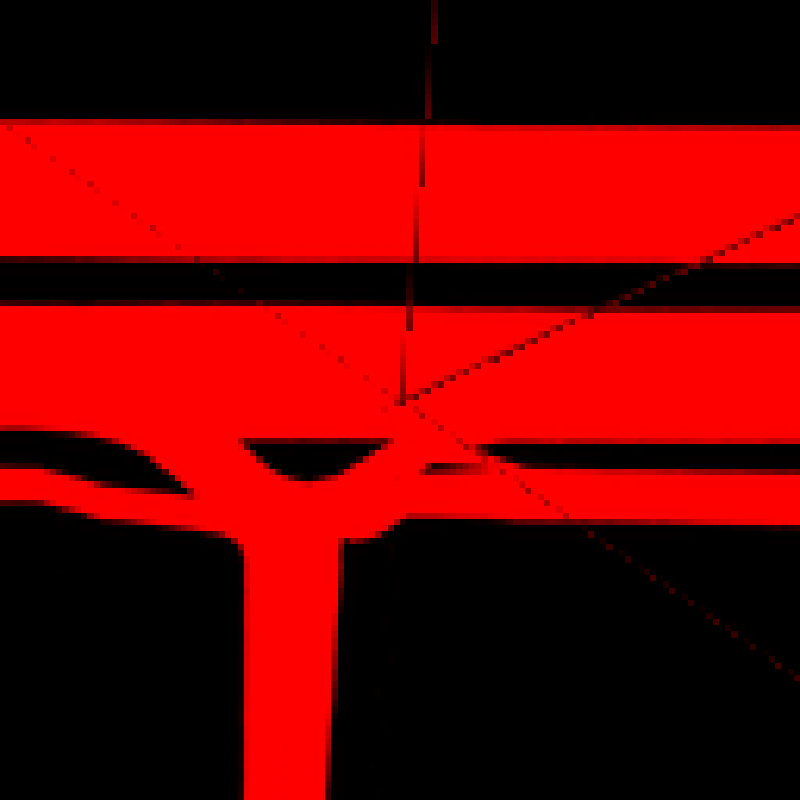

In [6]:
scene = 120 
sample = 0

data_loc = '/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data'
image_name = str(scene) + '_' + str(sample)

front_left = Image.open(os.path.join(data_loc, image_name + '_front_left.png'))
front = Image.open(os.path.join(data_loc, image_name + '_front.png'))
front_right = Image.open(os.path.join(data_loc, image_name + '_front_right.png'))
back_left = Image.open(os.path.join(data_loc, image_name + '_back_left.png'))
back = Image.open(os.path.join(data_loc, image_name + '_back.png'))
back_right = Image.open(os.path.join(data_loc, image_name + '_back_right.png'))

front_left = torchvision.transforms.functional.to_tensor(front_left)
front = torchvision.transforms.functional.to_tensor(front)
front_right = torchvision.transforms.functional.to_tensor(front_right)
back_left = torchvision.transforms.functional.to_tensor(back_left)
back = torchvision.transforms.functional.to_tensor(back)
back_right = torchvision.transforms.functional.to_tensor(back_right)

images = [
    front_left,
    front,
    front_right,
    back_left,
    back,
    back_right
]

ego = stitch_images(images)
ego = ego.resize((800, 800))
ego

In [5]:
front

tensor([[[0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         ...,
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922]]])

In [1]:
torchvision.transforms.ToPILImage(mode = None)(front)


NameError: name 'torchvision' is not defined